**评价预测结果与标签的分布**

<BarContainer object of 10 artists>

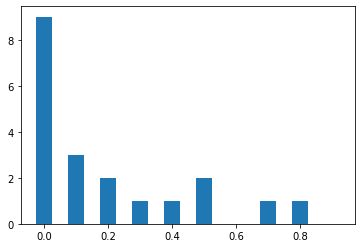

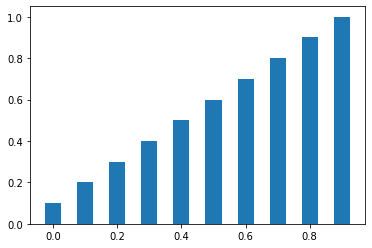

In [1]:
import numpy as np
import matplotlib.pyplot as plt
y = np.array([0.01,0.02,0.1,0.4,0.57,0.8,0.1,0.1,0.15,0.22,0.1,0.02,0.1,0.41,0.52,0.83,0.15,0.1,0.15,0.22])
y_hat = np.array([0.11,0.22,0.33,0.78,0.23,0.1,0.11,0.1,0.2,0.2,0.1,0.1,0.15,0.22,0.1,0.02,0.1,0.41,0.15,0.22])
diff = np.abs(y-y_hat)

def get_hist(y, min_value=0.0, max_value=1., step=0.1 ):
    sorted_id = sorted(range(len(y)), key=lambda k: y[k])
    y = np.array([y[i] for i in sorted_id])
    hist_index = {}
    iter_list = np.arange(min_value, max_value, step)
    for i in iter_list:
        start = i
        end = i+step
        hist_index[round(end,2)] = np.where((y>start)&(y<=end))[0]
    return hist_index, iter_list

hist_index, iter_list = get_hist(y,0.,1.,0.1)
hist_count = [len(hist_index[k]) for k in hist_index.keys()]
hist_error = {}
for key in hist_index.keys():
    hist_error[key] = np.average(diff[hist_index[key]]) if len(hist_index[key])!=0 else 0

fig = plt.figure()
plt.bar(iter_list, hist_count, width=0.05)
fig = plt.figure()
plt.bar(iter_list, hist_error, width=0.05)



**数据的分布**

In [51]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
from collections import Counter
from scipy.ndimage import convolve1d


def _get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'tria ng', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(
            base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        def laplace(x): return np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / \
            max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window


def _get_bin_idx(x):
    # label = label.detach().cpu().numpy()
    return min(int(x * np.float32(100)), 80)


def get_lds_weights(labels):
    # preds, labels: [Ns,], "Ns" is the number of total samples
    # assign each label to its corresponding bin (start from 0)
    # with your defined get_bin_idx(), return bin_index_per_label: [Ns,]
    bin_index_per_label = [_get_bin_idx(label) for label in labels]
    # calculate empirical (original) label distribution: [Nb,]
    # "Nb" is the number of bins
    # print("bin_index_per_label",len(bin_index_per_label),bin_index_per_label)
    Nb = max(bin_index_per_label)+1
    num_samples_of_bins = dict(Counter(bin_index_per_label))
    emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

    # lds_kernel_window: [ks,], here for example, we use gaussian, ks=5, sigma=2
    lds_kernel_window = _get_lds_kernel_window(
        kernel='gaussian', ks=5, sigma=2)
    # calculate effective label distribution: [Nb,]
    eff_label_dist = convolve1d(
        np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

    # print(len(eff_label_dist),eff_label_dist)
    # print(bin_index_per_label)
    eff_num_per_label = [eff_label_dist[bin_idx]
                         for bin_idx in bin_index_per_label]

    weights = [np.float32(1.0 / x) for x in eff_num_per_label]

    return weights

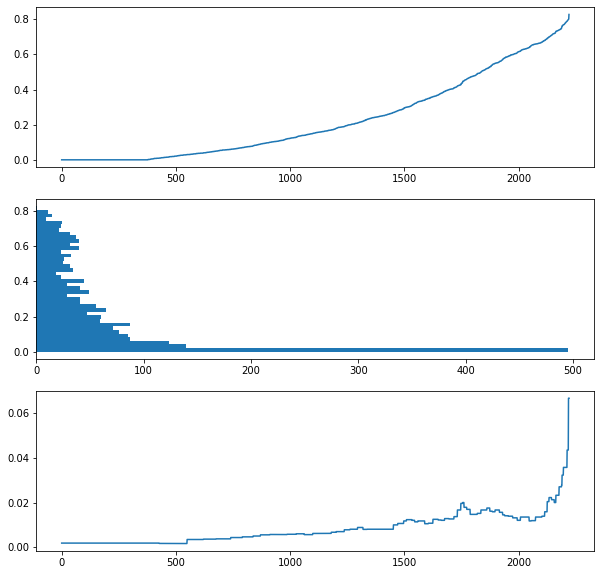

[495. 139. 124.  87.  85.  77.  71.  87.  59.  60.  47.  65.  56.  41.
  41.  29.  49.  41.  29.  44.  23.  18.  34.  31.  25.  26.  32.  23.
  40.  31.  40.  37.  31.  21.  23.  24.   9.  15.  11.   1.]
[0.     0.0207 0.0414 0.0621 0.0828 0.1035 0.1242 0.1449 0.1656 0.1863
 0.207  0.2277 0.2484 0.2691 0.2898 0.3105 0.3312 0.3519 0.3726 0.3933
 0.414  0.4347 0.4554 0.4761 0.4968 0.5175 0.5382 0.5589 0.5796 0.6003
 0.621  0.6417 0.6624 0.6831 0.7038 0.7245 0.7452 0.7659 0.7866 0.8073
 0.828 ]
2221.0


In [54]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
with open("../config.yaml",'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
data = pd.read_csv(f"../{config['D']['source']}")
names = data['name'].to_numpy()
labels = data['MPI3_fixed'].to_numpy()
weights = get_lds_weights(labels)

sorted_id = sorted(range(len(labels)), key=lambda k: labels[k], reverse=False)
labels = labels[sorted_id]
weights = np.array(weights)[sorted_id]
# print(weights)

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(labels)
plt.subplot(3,1,2)
n,bins,_=plt.hist(labels,bins=40, orientation='horizontal')
plt.subplot(3,1,3)
plt.plot(weights)
plt.show()
print(n)
print(bins)
print(np.sum(n))

**交叉验证**

In [63]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
with open("../config.yaml",'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
data = pd.read_csv(f"../{config['D']['source']}")
names = data['name'].to_numpy()
labels = data['MPI3_fixed'].to_numpy()
sorted_id = sorted(range(len(labels)), key=lambda k: labels[k], reverse=False)
names = names[sorted_id]
labels = labels[sorted_id]
fold = []
k = 5
for i in range(k):
    fold.append([v for v in range(0+i, len(names), k)])


(5,)
[list([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940, 945, 950, 955, 960, 965, 970, 975, 980, 985, 990, 995, 1000, 1005

/tmp/ipykernel_6967/734872752.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fold = np.array(fold)
